In [2]:
!pip install opendatasets
!pip install torchinfo

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path
import opendatasets as od
import cv2 as cv
import os

# Libraries from Scikit-learn
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

from collections import OrderedDict

# Getting the Dataset

In [4]:
if Path(".\\emotion-dataset").is_file():
    print("The dataset already exists. Skipping download...")
else:
    print("Downloading the datset...")
    od.download("https://www.kaggle.com/datasets/raunakgola/emotion-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: raunakgola
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/raunakgola/emotion-dataset


100%|██████████| 775M/775M [00:09<00:00, 81.7MB/s]


# Preprocessing and Formatting the Dataset

### apply some transformation on images

In [6]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

### Creating the images dataset to dataframe

In [9]:
# Step 1: Load the dataset
dataset = datasets.ImageFolder("/content/emotion-dataset/AffectNet2",transform=transform)

# Step 2: Extract image file paths and labels
file_paths = [item[0] for item in dataset.imgs]
labels = [item[1] for item in dataset.imgs]

# Step 3: Load each image and convert it to a NumPy array
image_arrays = [np.array(Image.open(fp)) for fp in file_paths]

# Step 4: Create a Pandas DataFrame with the image data and labels
df = pd.DataFrame({'image': image_arrays, 'label': labels})

# Display the DataFrame
df.head()

,image,label
0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0
1,"[[255, 231, 255, 128, 191, 249, 180, 146, 221,...",0
2,"[[84, 2, 63, 87, 64, 46, 70, 128, 234, 255, 25...",0
3,"[[255, 255, 255, 254, 254, 255, 255, 255, 255,...",0
4,"[[254, 255, 255, 251, 254, 255, 253, 254, 251,...",0


In [10]:
# Assuming 'df' is your original DataFrame
# Extract image arrays and labels
image_arrays = np.array(df['image'].tolist())
labels = df['label'].values

# Flatten each image array
flat_image_arrays = image_arrays.reshape(image_arrays.shape[0], -1)

# Create a DataFrame where each column represents a pixel
pixel_df = pd.DataFrame(flat_image_arrays)

# Add the labels as a column in the pixel DataFrame
pixel_df['label'] = labels

# Display the DataFrame
pixel_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,255,255,255,255,255,255,255,255,255,253,...,238,226,248,221,226,247,255,255,232,0
1,255,231,255,128,191,249,180,146,221,171,...,253,248,247,248,249,249,250,249,246,0
2,84,2,63,87,64,46,70,128,234,255,...,224,228,255,254,255,255,255,229,238,0
3,255,255,255,254,254,255,255,255,255,255,...,244,255,255,254,254,255,255,255,254,0
4,254,255,255,251,254,255,253,254,251,253,...,254,243,247,249,236,255,255,254,254,0


In [12]:
x = pixel_df.iloc[:,:-1]
y = pixel_df.iloc[:,-1]

# Reducing the Dimension Using Autoencoder

### setting up Device Agnostic Code

In [15]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### Custom Dataset Class

In [28]:
class CustomDataset(Dataset):
    def __init__(self, DataFrame):
        self.data = DataFrame

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming that the last column is the label
        sample = self.data.iloc[idx, :-1].values.astype(np.float32)
        label = self.data.iloc[idx, -1].astype(np.float32)

        # Reshape the sample to 256x256
        sample = np.reshape(sample, (256, 256))

        # Convert to tensors
        data = torch.tensor(sample)
        label = torch.tensor(label)

        return data, label

In [29]:
# Instantiate the dataset
custom_dataset = CustomDataset(pixel_df)

# Create a DataLoader
train_loader = DataLoader(custom_dataset, batch_size=32, shuffle=False)

### Extract the label and feature from dataframe

In [18]:
encoder = nn.Sequential(OrderedDict([
    ('Conv1',nn.Conv2d(1,16,kernel_size=(3,3),stride=(2,2),padding=(1,1),bias=False)),
    ('ReLU1',nn.ReLU()),
    ('MaxPool1',nn.MaxPool2d(kernel_size=(3,3),padding=(1,1),stride=(2,2))),
    ('Conv2',nn.Conv2d(16,16,kernel_size=(3,3),stride=(2,2),padding=(1,1),bias=False)),
    ('ReLU2',nn.ReLU()),
    ('MaxPool2',nn.MaxPool2d(kernel_size=(3,3),padding=(1,1),stride=(2,2))),
    ('Conv3',nn.Conv2d(16,16,kernel_size=(3,3),stride=(2,2),padding=(1,1),bias=False)),
    ('ReLU3',nn.ReLU()),
    ('Flatten',nn.Flatten()),
    ('Linear1',nn.Linear(1024,128,bias=False)),
    ('Linear2',nn.Linear(128,128,bias=False)),
    ('Linear3',nn.Linear(128,64,bias=False)),
]))

In [19]:
decoder = nn.Sequential(OrderedDict([
    ('Linear4',nn.Linear(64,128,bias=False)),
    ('Linear5',nn.Linear(128,128,bias=False)),
    ('Linear6',nn.Linear(128,4096,bias=False)),
    ('UnFlatten',nn.Unflatten(1,(16,16,16))),
    ('ConvTranspose1',nn.ConvTranspose2d(16,16,kernel_size=(3,3),padding=(1,1),output_padding=(1,1),stride=(2,2),bias=False)),
    ('ReLU5',nn.ReLU()),
    ('ConvTranspose2',nn.ConvTranspose2d(16,16,kernel_size=(3,3),padding=(1,1),output_padding=(1,1),stride=(2,2),bias=False)),
    ('ReLU6',nn.ReLU()),
    ('ConvTranspose3',nn.ConvTranspose2d(16,16,kernel_size=(3,3),padding=(1,1),output_padding=(1,1),stride=(2,2),bias=False)),
    ('ReLU7',nn.ReLU()),
    ('ConvTranspose4',nn.ConvTranspose2d(16,1,kernel_size=(3,3),padding=(1,1),output_padding=(1,1),stride=(2,2),bias=False)),
    ('Sigmoid',nn.Sigmoid())
]))

In [20]:
Autoencoder = nn.Sequential(OrderedDict([
    ('Encoder',encoder),
    ('Decoder',decoder)
])).to(device)

In [21]:
summary(Autoencoder,input_size=(1,1,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1, 256, 256]          --
├─Sequential: 1-1                        [1, 64]                   --
│    └─Conv2d: 2-1                       [1, 16, 128, 128]         144
│    └─ReLU: 2-2                         [1, 16, 128, 128]         --
│    └─MaxPool2d: 2-3                    [1, 16, 64, 64]           --
│    └─Conv2d: 2-4                       [1, 16, 32, 32]           2,304
│    └─ReLU: 2-5                         [1, 16, 32, 32]           --
│    └─MaxPool2d: 2-6                    [1, 16, 16, 16]           --
│    └─Conv2d: 2-7                       [1, 16, 8, 8]             2,304
│    └─ReLU: 2-8                         [1, 16, 8, 8]             --
│    └─Flatten: 2-9                      [1, 1024]                 --
│    └─Linear: 2-10                      [1, 128]                  131,072
│    └─Linear: 2-11                      [1, 128]                  16,384

### Loss Function and Optimizer

In [35]:
criterion = nn.MSELoss()
# criterion = nn.BCELoss()
optimizer = optim.Adam(Autoencoder.parameters(), lr=0.008)

### Training Loop

In [36]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        # Forward pass
        output = Autoencoder(img.reshape(32,1,256,256).to(device))
        # Compute KL divergence loss
        loss = criterion(output, img.reshape(32,1,256,256).to(device))

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

KeyboardInterrupt: 

In [38]:
Autoencoder.eval()
with torch.no_grad():
    for data in train_loader:
        img, _ = data
        output = Autoencoder(img.reshape(32,1,256,256).to(device))
        break

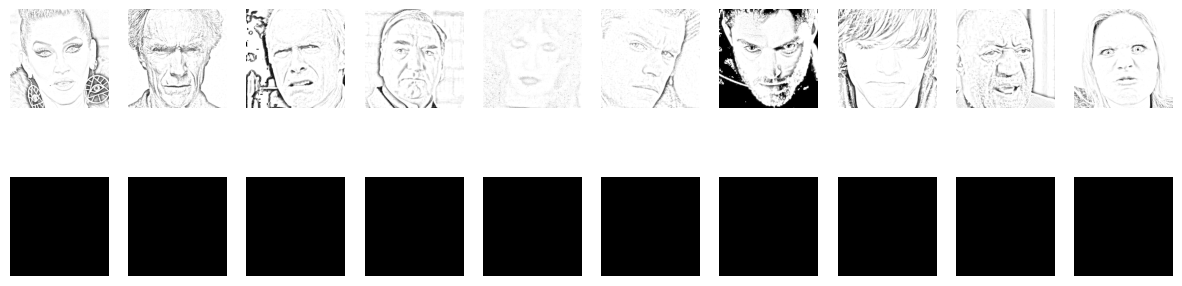

In [40]:
# Visualize the results
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(img[i].view(256, 256).cpu().numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(output[i].view(256, 256).cpu().numpy(), cmap='gray')
    axes[1, i].axis('off')
plt.show()

# Dimensionality Reduction

In [41]:
#Store all outputs in a list
all_outputs = []

# Pass each batch through the model
for data, _ in train_loader:
    # Reshape data to match the model's expected input shape, e.g., (batch_size, channels, height, width)
    data = data.view(data.size(0), 1, 256, 256)  # Adjust according to your dataset's shape

    # Pass the data through the model
    with torch.no_grad():
        output = encoder(data)

    # Convert output to numpy and store it
    all_outputs.append(output.numpy())

# Concatenate all outputs into a single numpy array
final_output_np = np.concatenate(all_outputs, axis=0)

print(final_output_np.shape)  # This should give you a shape of (33000, 64) if using the whole dataset

KeyboardInterrupt: 

# Visualizing the dataset using t-SNE

In [ ]:
tsne_res = TSNE(n_components=2, n_jobs = -1, random_state = 42).fit_transform(final_output_np)

In [ ]:
plt.figure(figsize=(7, 7))
plt.title("Visualization of t-SNE results on FER dataset ", fontsize=24, weight='bold')
sns.scatterplot(x=tsne_res[:, 0], y=tsne_res[:, 1], hue=y, palette="bright", legend="full")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.legend(fontsize=16);

# Fitting the emotions into clusters

In [ ]:
cluster = ['c1','c2','c3','c4','c5','c6']
emotions = ['angry','fear','happy','neutral','sad','shock']

In [ ]:
def making_clusters(x,y,emotion_no):
    emotion_c1 = 0
    emotion_c2 = 0
    emotion_c3 = 0
    emotion_c4 = 0
    emotion_c5 = 0
    emotion_c6 = 0
    emotion_C1 = []
    emotion_C2 = []
    emotion_C3 = []
    emotion_C4 = []
    emotion_C5 = []
    emotion_C6 = []
    for i in range(0,27240):
        if y[i]==emotion_no:
            y1 = tsne_res[i:i+1, 1]
            x1 = tsne_res[i:i+1, 0]
            if ((y1 - (1.7320*x1)) <= 0) and ((y1 >= 0)):
                emotion_c1 = 1 + emotion_c1
                emotion_C1.append(i)
            elif ((y1 - (1.7320*x1))>=0) and ((y1 + (1.7320*x1))>=0):
                emotion_c2 = 1 + emotion_c2
                emotion_C2.append(i)
            elif ((y1 + (1.7320*x1))<=0) and ((y1 >= 0)):
                emotion_c3 = 1 + emotion_c3
                emotion_C3.append(i)
            elif ((y1 - (1.7320*x1)) >= 0) and ((y1 <= 0)):
                emotion_c4 = 1 + emotion_c4
                emotion_C4.append(i)
            elif ((y1 - (1.7320*x1)) <= 0) and ((y1 + (1.7320*x1))<=0):
                emotion_c5 = 1 + emotion_c5
                emotion_C5.append(i)
            elif  ((y1 + (1.7320*x1))>=0) and ((y1 <= 0)):
                emotion_c6 = 1 + emotion_c6
                emotion_C6.append(i)
    emotion_c = [emotion_c1,emotion_c2,emotion_c3,emotion_c4,emotion_c5,emotion_c6]
    emotion_C = [emotion_C1,emotion_C2,emotion_C3,emotion_C4,emotion_C5,emotion_C6]

    return emotion_c,emotion_C

In [ ]:
angry_c , angry_C = making_clusters(x,y,0)
fear_c , fear_C = making_clusters(x,y,1)
happy_c , happy_C = making_clusters(x,y,2)
neutral_c , neutral_C = making_clusters(x,y,3)
sad_c , sad_C = making_clusters(x,y,4)
shock_c , shock_C = making_clusters(x,y,5)

# Visualizing the clusters obtained

In [ ]:
plt.figure(figsize=(14,15))
plt.subplot(321)
plt.grid()
sns.barplot(x=cluster,y=angry_c)
plt.title(label="best cluster area for angry")
plt.subplot(322)
plt.grid()
sns.barplot(x=cluster,y=fear_c)
plt.title(label="best cluster area for fear")
plt.subplot(323)
plt.grid()
sns.barplot(x=cluster,y=happy_c)
plt.title(label="best cluster area for happy")
plt.subplot(324)
plt.grid()
sns.barplot(x=cluster,y=neutral_c)
plt.title(label="best cluster area for neutral")
plt.subplot(325)
plt.grid()
sns.barplot(x=cluster,y=sad_c)
plt.title(label="best cluster area for sad")
plt.subplot(326)
plt.grid()
sns.barplot(x=cluster,y=shock_c)
plt.title(label="best cluster area for shock")
plt.show()

# Creating an array of the most suitable clusters

In [ ]:
### select cluster according to you

In [ ]:
listd = angry_C[5] + angry_C[1] + angry_C[2] + angry_C[3] + angry_C[4] + fear_C[3] + fear_C[1] + fear_C[2] + fear_C[4] + fear_C[0] + happy_C[0] + happy_C[1] + happy_C[4] + happy_C[2] + happy_C[5] + neutral_C[1] + neutral_C[2] + neutral_C[0] + neutral_C[3] + neutral_C[5] + sad_C[0] + sad_C[1] + sad_C[3] + sad_C[4] + sad_C[5] + shock_C[0] + shock_C[4] + shock_C[2] + shock_C[3] + shock_C[5]
len(listd)

In [ ]:
new_arr1 = np.delete(new_arr,listd,axis=0)
new_arr1 , new_arr1.shape

# Visualizing the newly formatted dataset using t-SNE

In [ ]:
X1 = new_arr1[:,:-1]
Y1 = new_arr1[:,-1]